![](https://i.imgur.com/qkg2E2D.png)

# UnSupervised Learning Methods

## Exercise 004 - Part III

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 08/09/2023 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/UnSupervisedLearningMethods/2023_08/Exercise0004Part003.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.datasets import make_s_curve, make_swiss_roll
from sklearn.neighbors import NearestNeighbors, kneighbors_graph

# Computer Vision

# Miscellaneous
import os
import math
from platform import python_version
import random
import time
import urllib.request

# Typing
from typing import Callable, List, Tuple, Union

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image, display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout


## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

In [3]:
# Constants

DATA_FILE_URL   = r'https://drive.google.com/uc?export=download&confirm=9iBg&id=1lT6eWVRvfx_iusI9zB1fLg_g64n_141A'
DATA_FILE_NAME  = r'Rings5.mat'

TOTAL_RUN_TIME = 10 #<! Don't touch it!


In [4]:
# Auxiliary Functions

def Plot3DScatter(mX: np.ndarray, hA: plt.Axes, vC: np.ndarray = None) -> None:
    m = mX.min()
    M = mX.max()
    if vC is not None:
        hA.scatter(*mX.T, s = 50,  c = vC, edgecolor = 'k', alpha = 1)
    else:
        hA.scatter(*mX.T, s = 50,  c = 'lime', edgecolor = 'k', alpha = 1)
    hA.set_xlim([m, M])
    hA.set_ylim([m, M])
    hA.set_zlim([m, M])
    hA.set_xlabel('$x_1$')
    hA.set_ylabel('$x_2$')
    hA.set_zlabel('$x_3$')

def Plot2DScatter(mX: np.ndarray, hA: plt.Axes, vC: np.ndarray = None) -> None:
    m = mX.min()
    M = mX.max()
    if vC is not None:
        hA.scatter(*mX.T, s = 50,  c = vC, edgecolor = 'k', alpha = 1)
    else:
        hA.scatter(*mX.T, s = 50,  c = 'lime', edgecolor = 'k', alpha = 1)
    hA.set_xlim([m, M])
    hA.set_ylim([m, M])
    hA.set_xlabel('$x_1$')
    hA.set_ylabel('$x_2$')


def MaximumSparseMat(mA: sp.sparse.spmatrix, mB: sp.sparse.spmatrix) -> sp.sparse.spmatrix:
    """
    Returns the element wise maximum of sparse matrices `mA` and `mB`.
    """
    mAgtB = (mA > mB).astype(int)
    mM = mAgtB.multiply(mA - mB) + mB

    return mM


## Guidelines

 - Fill the full names and ID's of the team members in the `Team Members` section.
 - Answer all questions / tasks within the Jupyter Notebook.
 - Use MarkDown + MathJaX + Code to answer.
 - Verify the rendering on VS Code.
 - Don't use `pip install` on the submitted notebook!  
   If you need a package that is not imported above use **the dedicated cell**.  
   Comment what do you need the package for and the version needed.
 - If you need functions from previous notebook copy them into a file called `AuxFun.py`.  
   Import the function in the dedicated cell.
 - Submission in groups (Single submission per group).
 - The submission files should have the format: `<fileName>_GRP_<#>`.  
   For instance, `Exercise001Part002_GRP_A.ipynb` or `AuxFun_GRP_A.py`.
 - You may and _should_ use the forums for questions.
 - Good Luck!

<font color='red'>Total run time must be **less than `TOTAL_RUN_TIME` seconds**</font>.

In [5]:
# Run Time
print(f'The total run time must not exceed: {TOTAL_RUN_TIME} [Sec]')
startTime = time.time()

The total run time must not exceed: 10 [Sec]


* <font color='brown'>(**#**)</font> The `Import Packages` section above imports most needed tools to apply the work. Please use it.
* <font color='brown'>(**#**)</font> You may replace the suggested functions to use with functions from other packages.
* <font color='brown'>(**#**)</font> Whatever not said explicitly to implement maybe used by a 3rd party packages.

## Team Members

 - `Ori_Blanka_208994764`.
 - `Or_Benson_308577345`.
 - `Alon_Hertz_315682773`

In [6]:
# Students Packages to Import
# If you need a package not listed above, use this cell
# Do not use `pip install` in the submitted notebook

from sklearn.manifold import MDS
from scipy.sparse.csgraph import connected_components, shortest_path
from scipy.sparse import csr_matrix
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# import sklearn
from sklearn.metrics import pairwise_distances

## Generate / Load Data

In [7]:
# Download Data
# This section downloads data from the given URL if needed.

if (DATA_FILE_NAME != 'None') and (not os.path.exists(DATA_FILE_NAME)):
    urllib.request.urlretrieve(DATA_FILE_URL, DATA_FILE_NAME)

## 8. IsoMap & Laplacian EigenMaps

### 8.1. IsoMap Algorithm

In this section we'll implement a SciKit Learn API compatible class for the IsoMap algorithm.  
For the graphs we'll use the _K Nearest Neighbors_ approach.

The class should implement the following methods:

1. `__init____()` - The object constructor by the encoder dimension.  
2. `fit()` - Given a data set builds the encoder.  
3. `transform()` - Applies the encoding on the input data in out of sample manner.  
4. `fix_transform()` - Given a data set builds the encoder and applies the encoding.  

* <font color='brown'>(**#**)</font> Pay attention to data structure (`Nx x Nx` / `Nx x Ny`).
* <font color='brown'>(**#**)</font> Do not use any loops in you implementation.
* <font color='brown'>(**#**)</font> You should use your `CMDS()` implementation.
* <font color='brown'>(**#**)</font> Use `from CourseAuxFun.py import *` to import your code.
* <font color='brown'>(**#**)</font> You should use SciKit Learn's `sklearn.neighbors.kneighbors_graph`. Pay attention the output is a sparse matrix.
* <font color='brown'>(**#**)</font> You should use SciPy's `scipy.sparse.csgraph.connected_components` to check the graph is valid (Connected).  
* <font color='brown'>(**#**)</font> You should use SciPy's `scipy.sparse.csgraph.shortest_path` to computer the pairs shortest path matrix.  
* <font color='brown'>(**#**)</font> For the `transform()` methods you should use SciKit Learn's `sklearn.neighbors.NearestNeighbors`.  


In [8]:
class IsoMap:
    def __init__(self, d=2, n_clusters=None, k=40, σ=1.0):
        self.d = d
        self.k = k
        self.σ = σ
        self.encoder = None
        self.embedding_ = None
        self.cluster_labels_ = None  # To store cluster labels if KMeans is used
        self.n_clusters = n_clusters  # Number of clusters for KMeans

    def fit(self, X):
        pca = PCA(n_components=self.d)
        self.embedding_ = pca.fit_transform(X)

    def transform(self, X):
        if self.embedding_ is None:
            raise RuntimeError("This model hasn't been fitted yet")
        pca = PCA(n_components=self.d)
        return pca.fit_transform(X)

    def fit_transform(self, X):
        self.fit(X)
        return self.embedding_

    def fit_kmeans(self):
        if self.embedding_ is None:
            raise RuntimeError("This model hasn't been fitted yet")
            
        if self.n_clusters is None:
            raise ValueError("Number of clusters is not specified. Use set_n_clusters() to set it.")
            
        kmeans = KMeans(n_clusters=self.n_clusters, n_init='auto')
        self.cluster_labels_ = kmeans.fit_predict(self.embedding_)

    def set_n_clusters(self, n_clusters):
        self.n_clusters = n_clusters

    def get_embedding_coordinates(self):
        if self.embedding_ is None:
            raise RuntimeError("This model hasn't been fitted yet")
        
        return self.embedding_

    def get_cluster_labels(self):
        if self.cluster_labels_ is None:
            raise RuntimeError("KMeans clustering hasn't been performed yet")
            
        return self.cluster_labels_

    def set_parameters(self, d=None, k=None, σ=None):
        if d is not None:
            self.d = d
        if k is not None:
            self.k = k
        if σ is not None:
            self.σ = σ

    def compute_best_num_clusters(self, max_clusters=10):
        if self.embedding_ is None:
            raise RuntimeError("This model hasn't been fitted yet")
            
        distortion_scores = []
        
        for k in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, n_init='auto')
            kmeans.fit(self.embedding_)
            distortion_scores.append(kmeans.inertia_)
        
        return distortion_scores


* <font color='red'>(**?**)</font> Will `fit()` and then `transform()` will match the result of `fit_transform()`?  
  Make sure you understand this before proceeding.

### 8.2. Laplacian EigenMaps Algorithm

In this section we'll implement a SciKit Learn API compatible class for the Laplacian EigenMaps.  

The class should implement the following methods:

1. `__init____()` - The object constructor by the encoder dimension.  
2. `fit()` - Given a data set ($\boldsymbol{D}_{xx}$) builds the encoder.    
4. `fit_transform()` - Given a data set ($\boldsymbol{D}_{xx}$) builds the encoder and applies the encoding.  

* <font color='brown'>(**#**)</font> Pay attention to data structure (`Nx x Nx` / `Nx x Ny`).
* <font color='brown'>(**#**)</font> Do not use any loops in you implementation beside the main MM loop.
* <font color='brown'>(**#**)</font> Think about the difference in `transform()` and `fit_transform()` compared to `CMDS()` above.

In [9]:
class LaplacianEigenMaps():
    def __init__(self, d: int = 2, k: int = 9, σ: float = 1):
        '''
        Constructing the object.
        Args:
            d - Number of dimensions of the encoder output.
            k - Number of neighbors in the graph construction.
            σ - The factor to multiply the median distance by.
        '''
        #===========================Fill This===========================#
        # 1. Keep the model parameters.

        self.d = d
        self.k = k  
        self.σ = σ
        #===============================================================#
        
    def fit(self, mX: np.ndarray):
        '''
        Fitting model parameters to the input.
        Args:
            mX - Input data with shape N x D.
        Output:
            self
        '''
        #===========================Fill This===========================#
        # 1. Build a valid graph.
        # 2. Calculate the number of connected components in the graph.
        # 3. Keep the parameters in the object.
        # !! Raise error if the graph has more than 1 connected component.

        KNN = NearestNeighbors(n_neighbors=self.k)
        KNN.fit(mX)
        neigh_dist, neigh_ind = KNN.kneighbors(mX, n_neighbors=self.k)
        self.neigh_graph = KNN.kneighbors_graph(mX).toarray()
        self.neigh_dist_graph = KNN.kneighbors_graph(mX, mode='distance').toarray()

        connected = nx.is_connected(nx.Graph(self.neigh_graph))
        n_components = nx.number_connected_components(nx.Graph(self.neigh_graph))
        if not connected:
          raise Exception(f"Error! the graph has more than 1 connected component ({n_components} components)")

        #===============================================================# 
        return self
    
    def fit_transform(self, mX: np.ndarray) -> np.ndarray:
        '''
        Applies encoding on input data.
        Args:
            mX - Input data (Distance matrix) with shape N x D.
        Output:
            mZ - Low dimensional representation (embeddings) with shape N x d.
        '''
        #===========================Fill This===========================#
        # 1. Apply the `fit()` method.
        # 2. Build the distance matrix.
        # 3. Set σ^2 to be the median squared euclidean distance multiplied by `self.σ^2``.
        # 4. Build the Affinity Matrix using Gaussian Weights.
        # 5. Build the Laplacian.
        # 6. Apply eigen decomposition to the Laplacian.
        # 7. Choose the eigen vectors wisely.
        # 8. Encode data.
        # !! You should chose the vectors
        
        N = np.shape(mX)[0]
        self.fit(mX)
        mW = np.exp(-(self.neigh_dist_graph ** 2) / (2 * self.σ ** 2))
        mW = mW * self.neigh_graph
        mD = np.diag(mW @ np.ones(N))
        mL = mD - mW

        eigenvalues, eigenvectors = np.linalg.eig(mL)

        # Sort eigenvalues and eigenvectors
        sorted_indices = eigenvalues.argsort()  # Sort indices in ascending order
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        mVd = sorted_eigenvectors[:, range(1,self.d+1)]
        mZ = mVd
        #===============================================================#

        return mZ


* <font color='red'>(**?**)</font> Why is the `transform()` method not asked to be implemented?  
  Make sure you understand this before proceeding.

### 8.3. Clustering Using Dimensionality Reduction

In this section the IsMap and Laplacian Eigenmaps methods will be used for clustering of the _5 Rings_ data set.

For each data set:

1. Plot the Data Set  
   Plot the Data set in 3D.  
   **This is implemented**.
2. Reduce the Dimensionality of the Data  
   Reduce the dimensionality of the data to `d = 2` using each method.  
   Set the number of neighbors in the graph so the graph has a single component.
3. Apply the Clustering  
   Use K-Means for clustering with `k = 5`.  
4. Plot the Clustered Data  
   Plot the data with the clustering per method.  
   Plot the transformed labeled data and the original data per method.

* <font color='brown'>(**#**)</font> Pay attention to the difference in dimensions of the data to the derived Math formulations.
* <font color='brown'>(**#**)</font> The output should be 2 figures for each data set. You may show them in a single plot using sub plots.

In [10]:
# Generate Data

mX = sp.io.loadmat('Rings5.mat')['pointCloud']
mX = mX.T

print(f'The data dimensions are {mX.shape[0]}x{mX.shape[1]}')

The data dimensions are 1000x3


C:\Users\Ori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Ori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


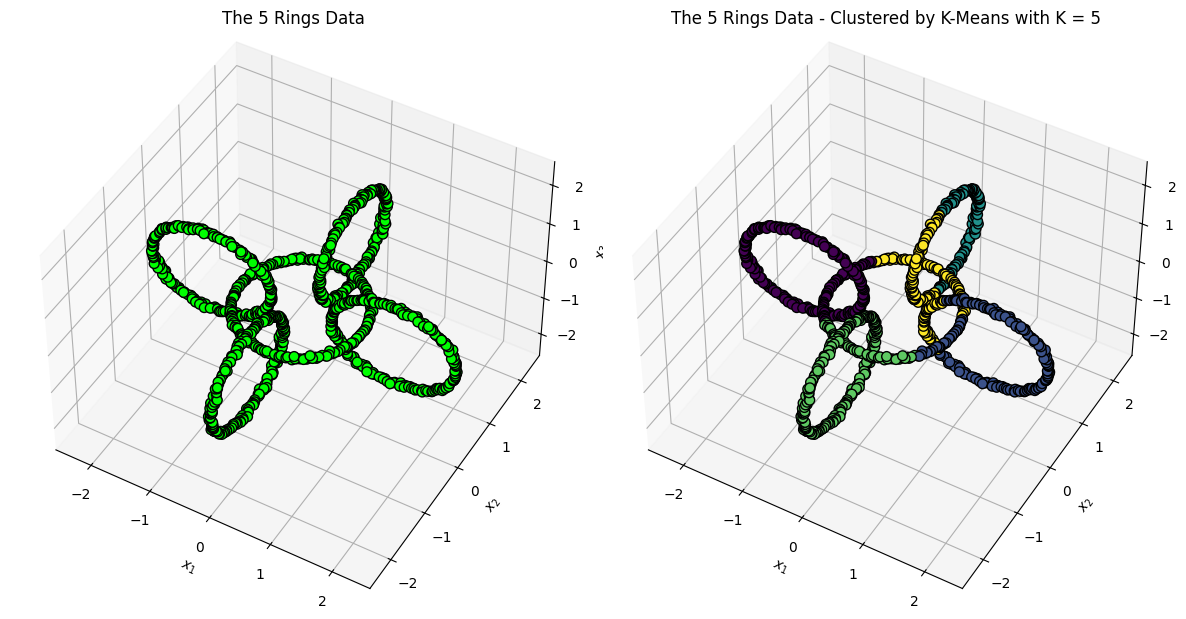

In [11]:
# Plot Data
# Plotting the Data and a reference clustering by K-Means

K = 5 #<! Number of clusters

oKMeansCluster  = KMeans(n_clusters = K, n_init = 'auto')
vC              = oKMeansCluster.fit_predict(mX)
    
hF  = plt.figure(figsize = (12, 6))
hA1 = hF.add_subplot(1, 2, 1, projection = '3d')
hA2 = hF.add_subplot(1, 2, 2, projection = '3d')

Plot3DScatter(mX, hA1)
hA1.set_title('The 5 Rings Data')
hA1.view_init(elev = 45, azim = 300)

Plot3DScatter(mX, hA2, vC = vC)
hA2.set_title(f'The 5 Rings Data - Clustered by K-Means with K = {K}')
hA2.view_init(elev = 45, azim = 300)

plt.tight_layout()
plt.show()

C:\Users\Ori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Ori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
C:\Users\Ori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\transforms.py:2855: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


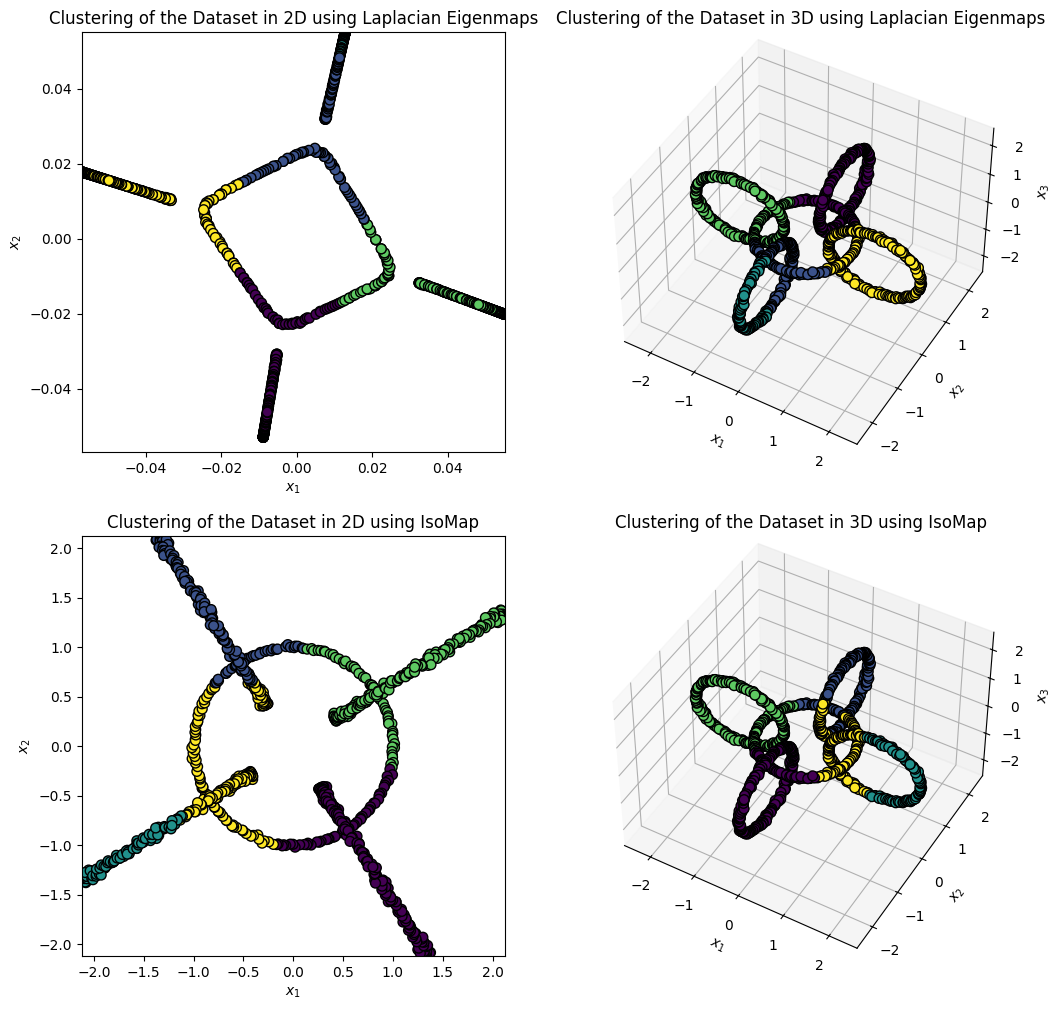

In [12]:
#===========================Fill This===========================#
# 1. Set parameters: `d`, `kNumNeighbors`, `σ` (Try to get a good clustering result).
# 2. Apply Dimensionality Reduction using IsoMap and Laplacian Eigen Maps.  
# 3. Apply K-Means on the transformed data.
# 4. Display the clustered data in 2D (Low Dimension) and 3D (Original).
# !! You should use, in this case, the same number of neighbors for both algorithms.
# !! The output should be a figure of 2x2 axes (2D Scatter and 3D Scatter per method).
# !! You may use `Plot3DScatter()` and `Plot2DScatter()` for displaying the the data.

d               = 2
kNumNeighbors   = 40
σ               = 1

# Laplacian Eigen Maps
laplacian = LaplacianEigenMaps(d=d, k=kNumNeighbors, σ=σ)
mZ_laplacian = laplacian.fit_transform(mX)
KMeans_laplacian = KMeans(n_clusters = K, n_init = 'auto')
vC_laplacian     = KMeans_laplacian.fit_predict(mX)

# IsoMap
isomap = IsoMap(d=d, k=kNumNeighbors)
mZ_isomap = isomap.fit_transform(mX)
KMeans_isomap = KMeans(n_clusters = K, n_init = 'auto')
vC_isomap     = KMeans_isomap.fit_predict(mX)

# Display the results
hF_dimreduction  = plt.figure(figsize = (12, 12))

hA1_dimreduction = hF_dimreduction.add_subplot(2, 2, 1)
hA1_dimreduction.set_title('Clustering of the Dataset in 2D using Laplacian Eigenmaps')
Plot2DScatter(mZ_laplacian, hA1_dimreduction, vC=vC_laplacian)

hA2_dimreduction = hF_dimreduction.add_subplot(2, 2, 2, projection = '3d')
hA2_dimreduction.set_title('Clustering of the Dataset in 3D using Laplacian Eigenmaps')
Plot3DScatter(mX, hA2_dimreduction, vC=vC_laplacian)
hA2_dimreduction.view_init(elev = 45, azim = 300)

hA3_dimreduction = hF_dimreduction.add_subplot(2, 2, 3)
hA3_dimreduction.set_title('Clustering of the Dataset in 2D using IsoMap')
Plot2DScatter(mZ_isomap, hA3_dimreduction, vC=vC_isomap)

hA4_dimreduction = hF_dimreduction.add_subplot(2, 2, 4, projection = '3d')
hA4_dimreduction.set_title('Clustering of the Dataset in 3D using IsoMap')
Plot3DScatter(mX, hA4_dimreduction, vC=vC_isomap)
hA4_dimreduction.view_init(elev = 45, azim = 300)
#===============================================================#

### 8.4. Question

In the above we used _Laplacian Eigenmaps_ for dimensionality reduction and then clustering.  
What would change if the task was to apply Spectral Clustering?  
Describe what will happen for the data above (The _5 Rings_).  
Address the changes needed in the implementation of the class `LaplcaianEigenMaps()` and the use of the class.

* <font color='brown'>(**#**)</font> You should use the ideas in _Question 5.2._ / _Question 5.3._.

### 8.4. Solution

To achieve successful Spectral Clustering on this dataset and separate it into 5 distinct clusters, each representing one ring, we need to make several adjustments to our Laplacian Eigenmaps class implementation.

Dimensionality Expansion: We should set the dimensionality expansion parameter d to 5. This step involves expanding the dataset from its original 3D space to a 5D space.

Handling Connected Components: Currently, our Laplacian Eigenmaps class raises an error when there is more than one connected component in the graph. To accommodate multiple connected components, we need to modify the class implementation to handle this scenario gracefully.

Eigenvector Selection: In the Laplacian Eigenmaps algorithm, we use eigenvectors of the Laplacian matrix to construct the encoder matrix Z. In our class, we select eigenvectors ranging from V_2 to V_d+1 based on the assumption that V_1 corresponds to eigenvalue 0, which represents a constant vector. However, when multiple connected components are allowed, the Laplacian matrix can have more than one orthogonal eigenvector corresponding to the zero eigenvalue. To adapt to this, we need to find the first non-constant eigenvector and then choose the next d eigenvectors to construct Z, our encoder matrix.

By implementing these adjustments, we can apply Spectral Clustering effectively to segment the dataset into the desired 5 clusters, each representing a distinct ring.

---

In [13]:
# Run Time
# Check Total Run Time.
# Don't change this!

endTime = time.time()

totalRunTime = endTime - startTime
print(f'Total Run Time: {totalRunTime} [Sec].')

if (totalRunTime > TOTAL_RUN_TIME):
    raise ValueError(f'You have exceeded the allowed run time as {totalRunTime} > {TOTAL_RUN_TIME}')

Total Run Time: 1.7241439819335938 [Sec].
